In [1]:
from keras import layers,models
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# recursive elimination of features ! to be checked later 
'''sklearn.feature_selection.RFECV'''

'sklearn.feature_selection.RFECV'

In [3]:
data=pd.read_csv('data/train.csv')
test=pd.read_csv('data/test.csv')
full=pd.concat([data,test])
full.shape

(1309, 12)

In [4]:
res=full[full['Survived'].isnull()]
res.shape

(418, 12)

In [5]:
full.tail()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
413,NaN,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236
414,39.0,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,PC 17758
415,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262
416,NaN,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309
417,NaN,NaN,C,22.3583,"Peter, Master. Michael J",1,1309,3,male,1,NaN,2668


In [6]:
full.drop(columns=['Cabin','PassengerId','Ticket'],inplace=True)
full.head()

,Age,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0


In [11]:
full.isnull().sum()

Age         263
Embarked      0
Fare          0
Name          0
Parch         0
Pclass        0
Sex           0
SibSp         0
Survived    418
dtype: int64

In [8]:
full['Sex']=full['Sex'].apply(lambda x : 1 if x=='male' else 0)

In [9]:
full=full[False==full['Embarked'].isnull()]
full['Embarked']=full['Embarked'].apply(lambda x : 0 if x=='S' else 1 if x=='C' else 2)

In [10]:
full['Fare']=full['Fare'].fillna(np.mean(full['Fare'].dropna().values))

# some data vis and EDA

In [12]:
'''g = sns.factorplot(y='Fare',x='Survived',kind='box',hue='Pclass', data=full,size=6,aspect=1.5)
plt.subplots_adjust(top=0.93)
g.fig.suptitle('Age vs Pclass cross Title', fontsize = 20)
'''

"g = sns.factorplot(y='Fare',x='Survived',kind='box',hue='Pclass', data=full,size=6,aspect=1.5)\nplt.subplots_adjust(top=0.93)\ng.fig.suptitle('Age vs Pclass cross Title', fontsize = 20)\n"

### Is there a coorelation between dead people and Sex ?

Text(0.5,1,'By Sex Survived')

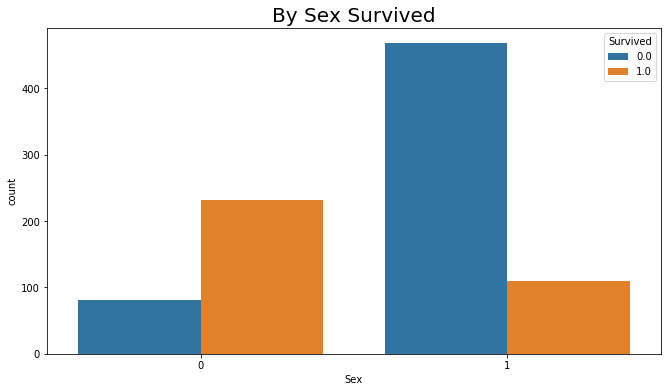

In [13]:
# A string coorelation can be observed 
fig = plt.figure(figsize=(11,6))
ax = sns.countplot(full['Sex'],hue=full['Survived'])
ax.set_title('By Sex Survived',fontsize = 20)

#### Fare Histograme (Before applyng rang on it )

Text(0.5,1,'By Fare Survived')

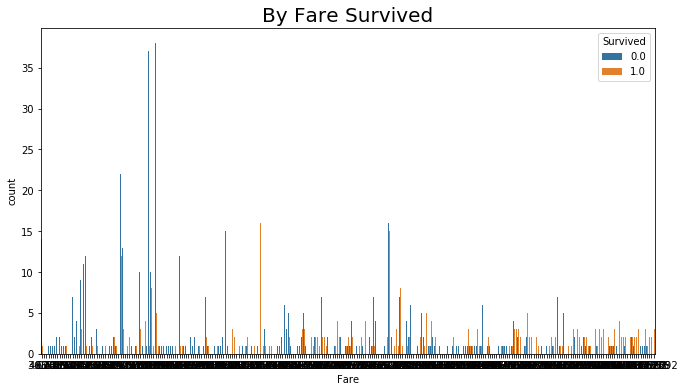

In [14]:

fig = plt.figure(figsize=(11,6))
ax = sns.countplot(full['Fare'],hue=full['Survived'])
ax.set_title('By Fare Survived',fontsize = 20)


## Transforming Fare to categorical 

In [15]:
fare_ranges = np.array([x*20 for x in range(30)])
full['Fare'] =fare_ranges.searchsorted(full.Fare)
full.head()

,Age,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived
0,22.0,0,1,"Braund, Mr. Owen Harris",0,3,1,1,0.0
1,38.0,1,4,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,1,1.0
2,26.0,0,1,"Heikkinen, Miss. Laina",0,3,0,0,1.0
3,35.0,0,3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,1,1.0
4,35.0,0,1,"Allen, Mr. William Henry",0,3,1,0,0.0


#### Fare Histograme (After applyng rang on it )

Text(0.5,1,'By Fare Survived')

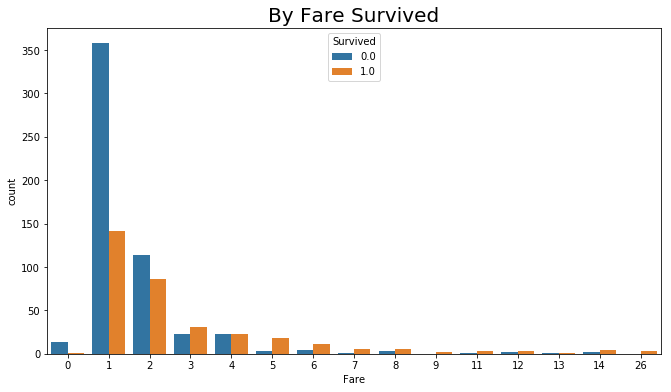

In [16]:

fig = plt.figure(figsize=(11,6))
ax = sns.countplot(full['Fare'],hue=full['Survived'])
ax.set_title('By Fare Survived',fontsize = 20)

Text(0.5,1,'Passenger has age')

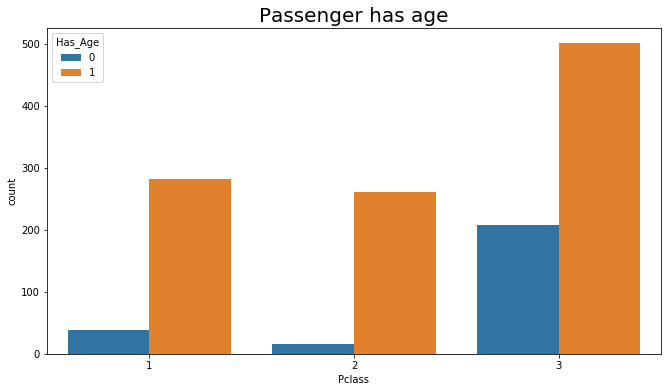

In [17]:
full['Has_Age'] = full['Age'].isnull().map(lambda x : 0 if x == True else 1)
fig = plt.figure(figsize=(11,6))
ax = sns.countplot(full['Pclass'],hue=full['Has_Age'])
ax.set_title('Passenger has age',fontsize = 20)


#### try extract age from name 

In [18]:
# extracted title using name
full['Title'] = full.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
full.head()

,Age,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Has_Age,Title
0,22.0,0,1,"Braund, Mr. Owen Harris",0,3,1,1,0.0,1,Mr
1,38.0,1,4,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,1,1.0,1,Mrs
2,26.0,0,1,"Heikkinen, Miss. Laina",0,3,0,0,1.0,1,Miss
3,35.0,0,3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,1,1.0,1,Mrs
4,35.0,0,1,"Allen, Mr. William Henry",0,3,1,0,0.0,1,Mr


Text(0.5,0.98,'Age vs Pclass cross Title')

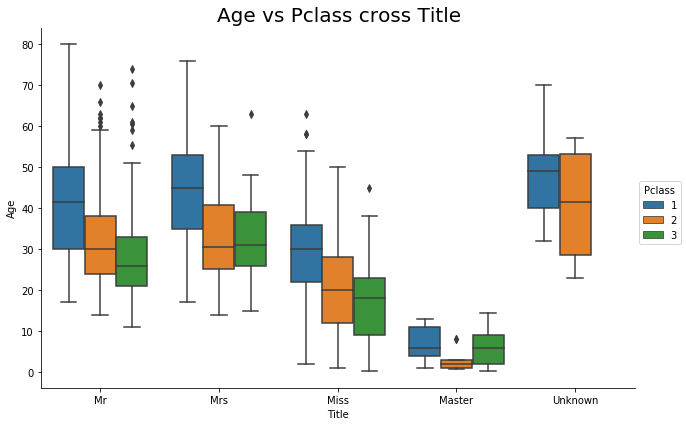

In [19]:
full['Title'] = full['Title'].replace(['Capt', 'Col', 'Countess', 'Don',
                                               'Dr', 'Dona', 'Jonkheer', 
                                                'Major','Rev','Sir'],'Unknown') 
full['Title'] = full['Title'].replace(['Mlle', 'Ms','Mme'],'Miss')
full['Title'] = full['Title'].replace(['Lady'],'Mrs')
g = sns.factorplot(y='Age',x='Title',kind='box',hue='Pclass', data=full, 
               size=6,aspect=1.5)
plt.subplots_adjust(top=0.93)
g.fig.suptitle('Age vs Pclass cross Title', fontsize = 20)


In [21]:
full.head()

,Age,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Has_Age,Title
0,22.0,0,1,"Braund, Mr. Owen Harris",0,3,1,1,0.0,1,Mr
1,38.0,1,4,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,1,1.0,1,Mrs
2,26.0,0,1,"Heikkinen, Miss. Laina",0,3,0,0,1.0,1,Miss
3,35.0,0,3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,1,1.0,1,Mrs
4,35.0,0,1,"Allen, Mr. William Henry",0,3,1,0,0.0,1,Mr


In [22]:
missing_mask = (full['Has_Age'] == 0)
pd.crosstab(full[missing_mask]['Pclass'],full[missing_mask]['Title'])

Title,Master,Miss,Mr,Mrs,Unknown
Pclass,,,,,
1,0,1,27,10,1
2,0,2,13,1,0
3,8,48,136,16,0


In [316]:
full.pivot_table(values='Age', index=['Pclass'], columns=['Title'],aggfunc=np.median)

Title,Master,Miss,Mr,Mrs,Unknown
Pclass,,,,,
1,6.0,30.0,41.5,45.0,49.0
2,2.0,20.0,30.0,30.5,41.5
3,6.0,18.0,26.0,31.0,NaN


In [23]:
full['Title'] = full['Title'].map({"Mr":0, "Unknown" : 1, "Master" : 2, "Miss" : 3, "Mrs" : 4 })
Pclass_title_pred = full.pivot_table(values='Age', index=['Pclass'], columns=['Title'],aggfunc=np.median).values
full['P_Ti_Age'] = full['Age']


In [24]:
print(Pclass_title_pred)

[[41.5 49.   6.  30.  45. ]
 [30.  41.5  2.  20.  30.5]
 [26.   nan  6.  18.  31. ]]


In [25]:
# filling Missing age with Pclass & Title
for i in range(0,5):
    # 0,1,2,3,4
    for j in range(1,4):
        # 1,2,3
            full.loc[(full.Age.isnull()) & (full.Pclass == j) & (full.Title == i),'P_Ti_Age'] = Pclass_title_pred[j-1, i]
full['P_Ti_Age'] = full['P_Ti_Age'].astype('int')

# filling Missing age with Title only
'''Ti_pred = full.groupby('Title')['Age'].median().values
full['Ti_Age'] = full['Age']
for i in range(0,5):
 # 0 1 2 3 4
    full.loc[(full.Age.isnull()) & (full.Title == i),'Ti_Age'] = Ti_pred[i]
full['Ti_Age'] = full['Ti_Age'].astype('int')'''


"Ti_pred = full.groupby('Title')['Age'].median().values\nfull['Ti_Age'] = full['Age']\nfor i in range(0,5):\n # 0 1 2 3 4\n    full.loc[(full.Age.isnull()) & (full.Title == i),'Ti_Age'] = Ti_pred[i]\nfull['Ti_Age'] = full['Ti_Age'].astype('int')"

In [28]:
full.tail()

,Age,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Has_Age,Title,P_Ti_Age
413,NaN,0,1,"Spector, Mr. Woolf",0,3,1,0,NaN,0,0,26
414,39.0,1,6,"Oliva y Ocana, Dona. Fermina",0,1,0,0,NaN,1,1,39
415,38.5,0,1,"Saether, Mr. Simon Sivertsen",0,3,1,0,NaN,1,0,38
416,NaN,0,1,"Ware, Mr. Frederick",0,3,1,0,NaN,0,0,26
417,NaN,1,2,"Peter, Master. Michael J",1,3,1,1,NaN,0,2,6


#### transform Age to ranges

In [29]:
age_ranges = np.array([16,100])
full['Age'] =age_ranges.searchsorted(full.Age)

full['P_Ti_Age'] = age_ranges.searchsorted(full.P_Ti_Age)
#full['Ti_AgeBin'] = age_ranges.searchsorted(full.Ti_Age)
#label = LabelEncoder()
#full['P_Ti_Code'] = label.fit_transform(full['P_Ti_AgeBin'])
#full['Ti_Code'] = label.fit_transform(full['Ti_AgeBin'])
full.head()

,Age,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Has_Age,Title,P_Ti_Age
0,1,0,1,"Braund, Mr. Owen Harris",0,3,1,1,0.0,1,0,1
1,1,1,4,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,1,1.0,1,4,1
2,1,0,1,"Heikkinen, Miss. Laina",0,3,0,0,1.0,1,3,1
3,1,0,3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,1,1.0,1,4,1
4,1,0,1,"Allen, Mr. William Henry",0,3,1,0,0.0,1,0,1


## XGboosting?

In [34]:
data_without_old_age=full.drop(columns=['Name','Has_Age','Age'])
data_without_old_age.head()

,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Title,P_Ti_Age
0,0,1,0,3,1,1,0.0,0,1
1,1,4,0,1,0,1,1.0,4,1
2,0,1,0,3,0,0,1.0,3,1
3,0,3,0,1,0,1,1.0,4,1
4,0,1,0,3,1,0,0.0,0,1


In [37]:
to_predict=data_without_old_age[data_without_old_age['Survived'].isnull()]
data=data_without_old_age[False==data_without_old_age['Survived'].isnull()]

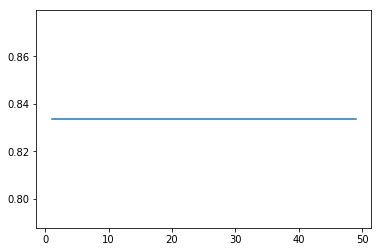

In [47]:
import warnings
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

estim=np.array([x for x in range(1,50)])
scores=[]
for n in range(49):
    gbm = xgb.XGBClassifier(max_depth=10, n_estimators=20, learning_rate=0.01,colsample_bytree=0.6)
    (x_tr,y_tr)=(data.drop('Survived',axis=1).values, data['Survived'].values)
    skf=StratifiedKFold(n_splits=10,shuffle=True,random_state=123)
    cv_scores=[]
    for tr_ind,val_ind in skf.split(x_tr, y_tr):
        X_tr, X_val=data.iloc[tr_ind],data.iloc[val_ind]
        gbm.fit(data.iloc[tr_ind].drop('Survived',axis=1).values,data.iloc[tr_ind].Survived.values)
        cv_scores.append(accuracy_score(gbm.predict(data.iloc[val_ind].drop('Survived',axis=1).values),data.iloc[val_ind].Survived.values))

    #cv_scores = cross_val_score(gbm, data.drop('Survived',axis=1).values, data['Survived'].values, cv=10)
    scores.append((np.asarray(cv_scores)).mean())
    #print((np.asarray(cv_scores)).mean())
plt.plot(estim,scores)


### After fixing the hyper parameter 


In [49]:
gbm = xgb.XGBClassifier(max_depth=10, n_estimators=20, learning_rate=0.01,colsample_bytree=0.6)
gbm.fit(data.drop('Survived',axis=1).values,data.Survived.values)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=20,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [53]:
to_predict[['Survived']].head()

,Survived
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


In [58]:
test['Survived']=gbm.predict(to_predict.drop('Survived',axis=1).values)
result_df=test[['PassengerId','Survived']]
result_df['Survived']=result_df['Survived'].astype('int')
result_df.to_csv('XGboost_output.csv',header=True,index=False)
result_df.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


### mean encoding

In [19]:
data.head()

,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived
0,0,0,0,3,1,1,0.0
1,1,3,0,1,0,1,1.0
2,0,0,0,3,0,0,1.0
3,0,2,0,1,0,1,1.0
4,0,0,0,3,1,0,0.0


In [551]:
'''for col in ['Sex','Fare']:
    data[col+'_mean_target']=0
    full[col+'_mean_target']=0'''
for col in ['Sex']:
    data[col+'_mean_target']=0
    full[col+'_mean_target']=0

In [552]:
data.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Sex_mean_target
0,22.0,0,7.2500,0,3,1,1,0.0,0
1,38.0,1,71.2833,0,1,0,1,1.0,0
2,26.0,0,7.9250,0,3,0,0,1.0,0
3,35.0,0,53.1000,0,1,0,1,1.0,0
4,35.0,0,8.0500,0,3,1,0,0.0,0


### Adding mean feature values by sex 

In [553]:
from sklearn.model_selection import StratifiedKFold
(x_tr,y_tr)=(data.values, data['Survived'].values)
skf=StratifiedKFold(n_splits=10,shuffle=True,random_state=123)
for tr_ind,val_ind in skf.split(x_tr, y_tr):
    X_tr, X_val=data.iloc[tr_ind],data.iloc[val_ind]
    for col in ['Sex']:
        means=X_val[col].map(X_tr.groupby(col).Survived.mean())
        data[col+'_mean_target'].iloc[val_ind]=means
    #data.iloc[val_ind]=X_val
    
    
    

In [20]:
data.head()

,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived
0,0,0,0,3,1,1,0.0
1,1,3,0,1,0,1,1.0
2,0,0,0,3,0,0,1.0
3,0,2,0,1,0,1,1.0
4,0,0,0,3,1,0,0.0


In [555]:
for col in ['Sex']:
    full['Sex_mean_target']=full['Sex'].map(data.groupby('Sex').Sex_mean_target.mean())


In [556]:
full.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Sex_mean_target
0,22.0,0,7.2500,0,3,1,1,0.0,0.188830
1,38.0,1,71.2833,0,1,0,1,1.0,0.740675
2,26.0,0,7.9250,0,3,0,0,1.0,0.740675
3,35.0,0,53.1000,0,1,0,1,1.0,0.740675
4,35.0,0,8.0500,0,3,1,0,0.0,0.188830


In [21]:
to_predict=full[full['Survived'].isnull()]

In [23]:
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

# Create the parameter grid: gbm_param_grid 
gbm_param_grid = {
    'n_estimators': range(8, 20),
    'max_depth': range(6, 10),
    'learning_rate': [.4, .45, .5, .55, .6],
    'colsample_bytree': [.6, .7, .8, .9, 1]
}

gbm = xgb.XGBClassifier(n_estimators=10)
#using hypertuning automatic##
xgb_random = RandomizedSearchCV(param_distributions=gbm_param_grid, 
                                    estimator = gbm, scoring = "accuracy", 
                                    verbose = 1, n_iter = 50, cv = 4)


# Fit randomized_mse to the data
xgb_random.fit(data.drop('Survived',axis=1).values,data.Survived.values)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", xgb_random.best_params_)
print("Best accuracy found: ", xgb_random.best_score_)


Fitting 4 folds for each of 50 candidates, totalling 200 fits
Best parameters found:  {'n_estimators': 8, 'max_depth': 6, 'learning_rate': 0.55, 'colsample_bytree': 0.7}
Best accuracy found:  0.8008998875140607


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.3s finished


0.8087972420837589
0.80658835546476
0.8032175689479061
0.8076864147088866
0.7986721144024514
0.793041368743616
0.7874361593462716
0.8009065372829417


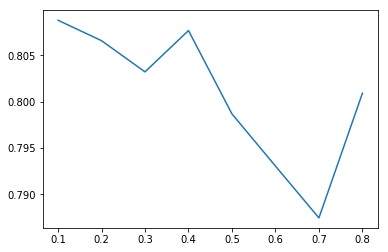

In [31]:
import warnings
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

estim=np.array([0.1*x for x in range(1,9)])
scores=[]
for n in range(8):
    gbm = xgb.XGBClassifier(max_depth=6, n_estimators=8, learning_rate=estim[n],colsample_bytree=0.7)
    (x_tr,y_tr)=(data.drop('Survived',axis=1).values, data['Survived'].values)
    skf=StratifiedKFold(n_splits=10,shuffle=True,random_state=123)
    cv_scores=[]
    for tr_ind,val_ind in skf.split(x_tr, y_tr):
        X_tr, X_val=data.iloc[tr_ind],data.iloc[val_ind]
        gbm.fit(data.iloc[tr_ind].drop('Survived',axis=1).values,data.iloc[tr_ind].Survived.values)
        cv_scores.append(accuracy_score(gbm.predict(data.iloc[val_ind].drop('Survived',axis=1).values),data.iloc[val_ind].Survived.values))

    #cv_scores = cross_val_score(gbm, data.drop('Survived',axis=1).values, data['Survived'].values, cv=10)
    scores.append((np.asarray(cv_scores)).mean())
    print((np.asarray(cv_scores)).mean())
plt.plot(estim,scores)


In [28]:
gbm = xgb.XGBClassifier(max_depth=6, n_estimators=8, learning_rate=0.55,colsample_bytree=0.7)
gbm.fit(data.drop('Survived',axis=1).values, data['Survived'].values)

res=xgb_random.predict(to_predict.drop(columns=['Survived']).values)

In [25]:
res_df=pd.DataFrame(columns=['PassengerId','Survived'],data=test['PassengerId'])

In [26]:
res_df['Survived']=res
res_df['Survived']=res_df['Survived'].apply(lambda  x :1 if x>0.1 else 0)
res_df.to_csv('XGboost.csv',header=True,index=False)

In [27]:
head.tail()

,PassengerId,Survived
413,1305,0
414,1306,1
415,1307,0
416,1308,0
417,1309,0
